Entrenamiento Multietiqueta:
==============================

En este archivo usaremos el modelo preentrenado xlm-roberta-base con fine-tuning
para aprovechar el conocimiento previo que tiene sobre el lenguaje. Esto nos permitirá:

- Conseguir mejores resultados con menos datos y en menos tiempo.
- Validar rápidamente la capacidad del modelo para detectar mensajes de odio.
- Enfocarnos en otras partes del proyecto como la integración o la optimización.

En un futuro, ampliaremos este modelo con más datos y etiquetas para mejorar
su precisión y adaptarlo mejor a las distintas categorías de mensajes de odio.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, EarlyStoppingCallback
from datasets import Dataset
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

In [ ]:
# Configurar reproducibilidad
torch.manual_seed(42)
np.random.seed(42)

## 1. Cargamos los datos:

In [5]:
df_url = pd.read_csv("https://raw.githubusercontent.com/Yael-Parra/sentiment-analyzer-inc/feature/eda/eda/data/youtube_dataset_cleaned.csv.gz")

In [6]:
df_url. info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   comment_id           1000 non-null   object
 1   video_id             1000 non-null   object
 2   text                 1000 non-null   object
 3   is_toxic             1000 non-null   bool  
 4   is_abusive           1000 non-null   bool  
 5   is_threat            1000 non-null   bool  
 6   is_provocative       1000 non-null   bool  
 7   is_obscene           1000 non-null   bool  
 8   is_hatespeech        1000 non-null   bool  
 9   is_racist            1000 non-null   bool  
 10  is_nationalist       1000 non-null   bool  
 11  is_sexist            1000 non-null   bool  
 12  is_homophobic        1000 non-null   bool  
 13  is_religious_hate    1000 non-null   bool  
 14  is_radicalism        1000 non-null   bool  
 15  comment_length       1000 non-null   int64 
 16  word_co

### Seleccionamos las columnas relevantes, definimos las categorías: 

In [7]:
bool_cols = ['is_toxic', 'is_abusive', 'is_threat', 'is_provocative', 'is_obscene',
              'is_hatespeech', 'is_racist', 'is_nationalist', 'is_sexist', 'is_homophobic',
              'is_religious_hate', 'is_radicalism']

In [8]:
df_multi = df_url[['text'] + bool_cols]

## Análisis de distribución de etiquetas


Distribución de etiquetas:
is_toxic             0.462
is_abusive           0.353
is_provocative       0.161
is_hatespeech        0.138
is_racist            0.125
is_obscene           0.100
is_threat            0.021
is_religious_hate    0.012
is_nationalist       0.008
is_sexist            0.001
is_homophobic        0.000
is_radicalism        0.000
dtype: float64


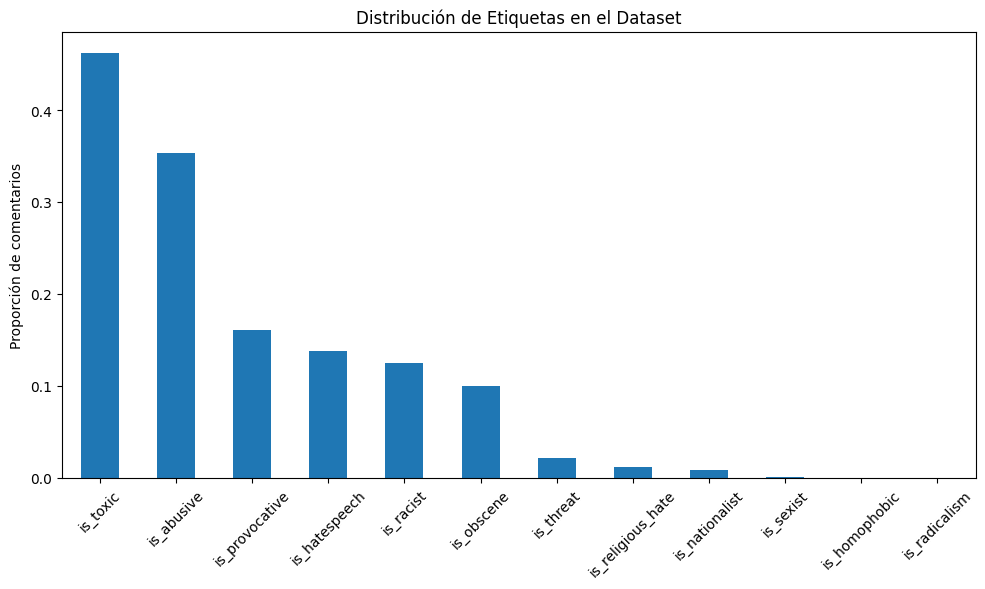

In [9]:
label_distribution = df_multi[bool_cols].mean().sort_values(ascending=False)
print("\nDistribución de etiquetas:")
print(label_distribution)

plt.figure(figsize=(10, 6))
label_distribution.plot(kind='bar')
plt.title('Distribución de Etiquetas en el Dataset')
plt.ylabel('Proporción de comentarios')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Algunas etiquetas son muy raras.

## 2. Modelado Multietiqueta con XLM-RoBERTa

- Cargamos el tokenizador:

In [10]:
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
def tokenize_funct(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128,
    )

### Dividimos el dataset en entrenamiento, validación y test manteniendo la proporción de cada etiqueta en cada conjunto, para eso usamos Iterative stratification que es un algoritmo especializado para multietiqueta, así aseguramos una evaluación más justa: 

In [ ]:
def advanced_multilabel_split(df, test_size=0.2, val_size=0.1, random_state=42):
    """
    Triple split estratificado para train/val/test con balanceo multietiqueta
    """
    try:
        X = df[['text']].values
        y = df[bool_cols].values

        msss = MultilabelStratifiedShuffleSplit(
            n_splits=1, test_size=test_size+val_size, random_state=random_state
        )
        train_idx, temp_idx = next(msss.split(X, y))
        
        X_temp = X[temp_idx]
        y_temp = y[temp_idx]
        temp_df = df.iloc[temp_idx]
        
        msss_temp = MultilabelStratifiedShuffleSplit(
            n_splits=1, test_size=test_size/(test_size+val_size), random_state=random_state
        )
        val_idx_temp, test_idx_temp = next(msss_temp.split(X_temp, y_temp))
        
        train_df = df.iloc[train_idx]
        val_df = temp_df.iloc[val_idx_temp]
        test_df = temp_df.iloc[test_idx_temp]
        
    except ImportError:
        print("Usando estratificación manual (instala iterative-stratification para mejor balanceo)")

        df_copy = df.copy()
        df_copy['label_combination'] = df_copy[bool_cols].apply(
            lambda x: ''.join(x.astype(str)), axis=1
        )
        
        combination_counts = df_copy['label_combination'].value_counts()
        rare_combinations = combination_counts[combination_counts < 10].index
        df_copy.loc[df_copy['label_combination'].isin(rare_combinations), 'label_combination'] = 'rare'
        

        train_df, temp_df = train_test_split(
            df_copy, test_size=test_size+val_size, random_state=random_state,
            stratify=df_copy['label_combination']
        )
        
        val_df, test_df = train_test_split(
            temp_df, test_size=test_size/(test_size+val_size), random_state=random_state,
            stratify=temp_df['label_combination']
        )

        train_df = train_df.drop('label_combination', axis=1)
        val_df = val_df.drop('label_combination', axis=1)
        test_df = test_df.drop('label_combination', axis=1)
    
    return train_df, val_df, test_df


train_df, val_df, test_df = advanced_multilabel_split(df_multi, test_size=0.15, val_size=0.15, random_state=42)


def analyze_dataset_balance(train_df, val_df, test_df, bool_cols):
    """
    Analiza el balanceo de datasets
    """
    print("="*80)
    print("ANÁLISIS DE BALANCEO DE DATASETS")
    print("="*80)
    
    datasets = {'Train': train_df, 'Validation': val_df, 'Test': test_df}
    
    for name, df in datasets.items():
        print(f"\n{name} Dataset: {len(df)} samples")
        print("-" * 40)
        
        for col in bool_cols:
            pos_count = df[col].sum()
            neg_count = len(df) - pos_count
            pos_pct = pos_count / len(df) * 100
            
            print(f"{col:15}: {pos_count:4d} pos ({pos_pct:5.1f}%) | {neg_count:4d} neg ({100-pos_pct:5.1f}%)")
    
    # Verificamos la similitud de distribuciones
    print(f"\n{'='*80}")
    print("VERIFICACIÓN DE CONSISTENCIA")
    print("="*80)
    
    for col in bool_cols:
        train_pct = train_df[col].mean() * 100
        val_pct = val_df[col].mean() * 100
        test_pct = test_df[col].mean() * 100
        
        max_diff = max(abs(train_pct - val_pct), abs(train_pct - test_pct), abs(val_pct - test_pct))
        status = "✅ Balanceado" if max_diff < 5 else "⚠️ Desbalanceado"
        
        print(f"{col:15}: Train={train_pct:5.1f}% Val={val_pct:5.1f}% Test={test_pct:5.1f}% | Diff={max_diff:4.1f}% {status}")

analyze_dataset_balance(train_df, val_df, test_df, bool_cols)

ANÁLISIS DE BALANCEO DE DATASETS

Train Dataset: 700 samples
----------------------------------------
is_toxic       :  323 pos ( 46.1%) |  377 neg ( 53.9%)
is_abusive     :  247 pos ( 35.3%) |  453 neg ( 64.7%)
is_threat      :   15 pos (  2.1%) |  685 neg ( 97.9%)
is_provocative :  113 pos ( 16.1%) |  587 neg ( 83.9%)
is_obscene     :   70 pos ( 10.0%) |  630 neg ( 90.0%)
is_hatespeech  :   97 pos ( 13.9%) |  603 neg ( 86.1%)
is_racist      :   88 pos ( 12.6%) |  612 neg ( 87.4%)
is_nationalist :    6 pos (  0.9%) |  694 neg ( 99.1%)
is_sexist      :    1 pos (  0.1%) |  699 neg ( 99.9%)
is_homophobic  :    0 pos (  0.0%) |  700 neg (100.0%)
is_religious_hate:    8 pos (  1.1%) |  692 neg ( 98.9%)
is_radicalism  :    0 pos (  0.0%) |  700 neg (100.0%)

Validation Dataset: 150 samples
----------------------------------------
is_toxic       :   72 pos ( 48.0%) |   78 neg ( 52.0%)
is_abusive     :   53 pos ( 35.3%) |   97 neg ( 64.7%)
is_threat      :    3 pos (  2.0%) |  147 neg ( 98.0

## Convertir a formato HuggingFace

In [ ]:
train_dataset = Dataset.from_pandas(train_df)
valid_dataset = Dataset.from_pandas(valid_df)

## Tokenizar

In [15]:
train_dataset = train_dataset.map(tokenize_funct, batched=True)
valid_dataset = valid_dataset.map(tokenize_funct, batched=True)

Map: 100%|██████████| 200/200 [00:00<00:00, 3779.62 examples/s]


## Prepararamos etiquetas

In [16]:
def prepare_labels(batch):
    batch["labels"] = [
        [float(batch[col][i]) for col in bool_cols]
        for i in range(len(batch["text"]))
    ]
    return batch

train_dataset = train_dataset.map(prepare_labels, batched=True)
valid_dataset = valid_dataset.map(prepare_labels, batched=True)

Map: 100%|██████████| 200/200 [00:00<00:00, 11020.39 examples/s]


In [17]:
# Data Collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 3. Configuración del Modelo y Entrenamiento

- Cargamos el modelo preentrenado, le configuramos para que use las etiquetas de antes, especificamos que es multietiqueta.

In [18]:
model = AutoModelForSequenceClassification.from_pretrained(
    "xlm-roberta-base",
    num_labels=len(bool_cols),
    problem_type="multi_label_classification" 
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Métricas personalizadas

In [ ]:
def compute_metrics(eval_pred):
    """
    Función de métricas comprehensiva para multietiqueta
    """
    logits, labels = eval_pred
    predictions = torch.sigmoid(torch.tensor(logits))
    

    threshold = 0.35
    preds = (predictions > threshold).int().numpy()
    
    metrics = {}
    
    class_metrics = []
    
    for i, col in enumerate(bool_cols):
        target = labels[:, i]
        prediction = preds[:, i]
        
        # Matriz de confusión
        tn = ((target == 0) & (prediction == 0)).sum()
        fp = ((target == 0) & (prediction == 1)).sum() 
        fn = ((target == 1) & (prediction == 0)).sum()
        tp = ((target == 1) & (prediction == 1)).sum()
        
        # Evitar división por cero
        precision_pos = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall_pos = tp / (tp + fn) if (tp + fn) > 0 else 0
        precision_neg = tn / (tn + fn) if (tn + fn) > 0 else 0
        recall_neg = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        f1_pos = 2 * precision_pos * recall_pos / (precision_pos + recall_pos) if (precision_pos + recall_pos) > 0 else 0
        f1_neg = 2 * precision_neg * recall_neg / (precision_neg + recall_neg) if (precision_neg + recall_neg) > 0 else 0
        
        # Métricas balanceadas
        balanced_accuracy = (recall_pos + recall_neg) / 2
        specificity = recall_neg
        
        # Guardamos las métricas
        metrics[f"{col}_precision"] = precision_pos
        metrics[f"{col}_recall"] = recall_pos
        metrics[f"{col}_f1"] = f1_pos
        metrics[f"{col}_precision_neg"] = precision_neg
        metrics[f"{col}_recall_neg"] = recall_neg
        metrics[f"{col}_f1_neg"] = f1_neg
        metrics[f"{col}_balanced_acc"] = balanced_accuracy
        metrics[f"{col}_specificity"] = specificity
        
        # Para promedios
        class_metrics.append({
            'precision': precision_pos,
            'recall': recall_pos,
            'f1': f1_pos,
            'balanced_acc': balanced_accuracy,
            'support': target.sum()
        })
    
    # Métricas agregadas
    total_support = sum([cm['support'] for cm in class_metrics])
    
    # Macro (promedio simple)
    metrics["macro_precision"] = np.mean([cm['precision'] for cm in class_metrics])
    metrics["macro_recall"] = np.mean([cm['recall'] for cm in class_metrics])
    metrics["macro_f1"] = np.mean([cm['f1'] for cm in class_metrics])
    metrics["macro_balanced_acc"] = np.mean([cm['balanced_acc'] for cm in class_metrics])
    
    # Weighted (por soporte)
    if total_support > 0:
        metrics["weighted_precision"] = sum([cm['precision'] * cm['support'] for cm in class_metrics]) / total_support
        metrics["weighted_recall"] = sum([cm['recall'] * cm['support'] for cm in class_metrics]) / total_support
        metrics["weighted_f1"] = sum([cm['f1'] * cm['support'] for cm in class_metrics]) / total_support
    else:
        metrics["weighted_precision"] = 0
        metrics["weighted_recall"] = 0
        metrics["weighted_f1"] = 0
    
    return metrics

## Argumentos de entrenamiento

In [38]:
training_args = TrainingArguments(
    output_dir="./xlm-roberta-multilabel-robust",
    
    # Entrenamiento
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=1,  # Batch efectivo = 32
    
    # Evaluación y guardado
    eval_strategy="epoch",
    #eval_steps=100,  # Evaluar frecuentemente
    save_strategy="epoch", 
    #save_steps=100,
    logging_steps=50,
    
    # Optimización
    learning_rate=2e-5,  # Conservador para evitar overfitting
    lr_scheduler_type="cosine",  # Scheduler que reduce LR gradualmente
    warmup_ratio=0.1,
    weight_decay=0.05,  # Regularización más fuerte
    
    # Anti-overfitting
    load_best_model_at_end=True,
    metric_for_best_model="eval_macro_f1",
    greater_is_better=True,
    save_total_limit=3,  # Solo guardar 3 mejores checkpoints
    
    # Rendimiento
    fp16=True,  # Activar para acelerar
    dataloader_num_workers=4,
    dataloader_pin_memory=True,
    
    # Logging
    report_to="none",
    logging_dir="./logs",
    
    # Reproducibilidad
    seed=42,
    data_seed=42,
)

# Callbacks anti-overfitting
callbacks = [
    EarlyStoppingCallback(
        early_stopping_patience=5,  # Parar si no mejora en 5 evaluaciones
        early_stopping_threshold=0.001  # Mejora mínima requerida
    )
]

## Trainer

In [39]:
# Reemplaza la configuración del modelo
model = AutoModelForSequenceClassification.from_pretrained(
    "xlm-roberta-base",
    num_labels=len(bool_cols),
    problem_type="multi_label_classification",
    hidden_dropout_prob=0.3,  # Dropout más fuerte
    attention_probs_dropout_prob=0.3,
    classifier_dropout=0.3
)

# Congelar algunas capas iniciales para evitar overfitting
def freeze_early_layers(model, num_layers_to_freeze=6):
    """
    Congela las primeras capas para reducir overfitting
    """
    for param in model.roberta.embeddings.parameters():
        param.requires_grad = False
    
    for layer in model.roberta.encoder.layer[:num_layers_to_freeze]:
        for param in layer.parameters():
            param.requires_grad = False
    
    print(f"Congeladas las primeras {num_layers_to_freeze} capas del encoder")

# Aplicar congelación parcial
freeze_early_layers(model, num_layers_to_freeze=4)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Congeladas las primeras 4 capas del encoder


In [40]:
class OverfittingMonitor:
    """
    Monitor de overfitting durante entrenamiento
    """
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.val_metrics = []
    
    def log_metrics(self, logs):
        if 'train_loss' in logs:
            self.train_losses.append(logs['train_loss'])
        if 'eval_loss' in logs:
            self.val_losses.append(logs['eval_loss'])
        if 'eval_macro_f1' in logs:
            self.val_metrics.append(logs['eval_macro_f1'])
    
    def check_overfitting(self):
        if len(self.train_losses) >= 3 and len(self.val_losses) >= 3:
            recent_train = np.mean(self.train_losses[-3:])
            recent_val = np.mean(self.val_losses[-3:])
            
            overfitting_ratio = (recent_val - recent_train) / recent_train * 100
            
            print(f"Overfitting check: {overfitting_ratio:.2f}%")
            
            if overfitting_ratio > 5:
                print("⚠️  Posible overfitting detectado!")
            else:
                print("✅ Sin overfitting significativo")
            
            return overfitting_ratio
        return 0

# Crear datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Tokenizar
train_dataset = train_dataset.map(tokenize_funct, batched=True)
val_dataset = val_dataset.map(tokenize_funct, batched=True)
test_dataset = test_dataset.map(tokenize_funct, batched=True)

# Preparar etiquetas
train_dataset = train_dataset.map(prepare_labels, batched=True)
val_dataset = val_dataset.map(prepare_labels, batched=True)
test_dataset = test_dataset.map(prepare_labels, batched=True)

# Crear trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=callbacks,
)

# Entrenar con monitoreo
print("🚀 Iniciando entrenamiento con monitoreo anti-overfitting...")
training_results = trainer.train()

# Guardar modelo
model_dir = "./model-xlm-roberta-robust"
trainer.save_model(model_dir)
tokenizer.save_pretrained(model_dir)

print(f"✅ Modelo robusto guardado en: {model_dir}")

Map: 100%|██████████| 150/150 [00:00<00:00, 3979.11 examples/s]


🚀 Iniciando entrenamiento con monitoreo anti-overfitting...


Epoch,Training Loss,Validation Loss,Is Toxic Precision,Is Toxic Recall,Is Toxic F1,Is Toxic Precision Neg,Is Toxic Recall Neg,Is Toxic F1 Neg,Is Toxic Balanced Acc,Is Toxic Specificity,Is Abusive Precision,Is Abusive Recall,Is Abusive F1,Is Abusive Precision Neg,Is Abusive Recall Neg,Is Abusive F1 Neg,Is Abusive Balanced Acc,Is Abusive Specificity,Is Threat Precision,Is Threat Recall,Is Threat F1,Is Threat Precision Neg,Is Threat Recall Neg,Is Threat F1 Neg,Is Threat Balanced Acc,Is Threat Specificity,Is Provocative Precision,Is Provocative Recall,Is Provocative F1,Is Provocative Precision Neg,Is Provocative Recall Neg,Is Provocative F1 Neg,Is Provocative Balanced Acc,Is Provocative Specificity,Is Obscene Precision,Is Obscene Recall,Is Obscene F1,Is Obscene Precision Neg,Is Obscene Recall Neg,Is Obscene F1 Neg,Is Obscene Balanced Acc,Is Obscene Specificity,Is Hatespeech Precision,Is Hatespeech Recall,Is Hatespeech F1,Is Hatespeech Precision Neg,Is Hatespeech Recall Neg,Is Hatespeech F1 Neg,Is Hatespeech Balanced Acc,Is Hatespeech Specificity,Is Racist Precision,Is Racist Recall,Is Racist F1,Is Racist Precision Neg,Is Racist Recall Neg,Is Racist F1 Neg,Is Racist Balanced Acc,Is Racist Specificity,Is Nationalist Precision,Is Nationalist Recall,Is Nationalist F1,Is Nationalist Precision Neg,Is Nationalist Recall Neg,Is Nationalist F1 Neg,Is Nationalist Balanced Acc,Is Nationalist Specificity,Is Sexist Precision,Is Sexist Recall,Is Sexist F1,Is Sexist Precision Neg,Is Sexist Recall Neg,Is Sexist F1 Neg,Is Sexist Balanced Acc,Is Sexist Specificity,Is Homophobic Precision,Is Homophobic Recall,Is Homophobic F1,Is Homophobic Precision Neg,Is Homophobic Recall Neg,Is Homophobic F1 Neg,Is Homophobic Balanced Acc,Is Homophobic Specificity,Is Religious Hate Precision,Is Religious Hate Recall,Is Religious Hate F1,Is Religious Hate Precision Neg,Is Religious Hate Recall Neg,Is Religious Hate F1 Neg,Is Religious Hate Balanced Acc,Is Religious Hate Specificity,Is Radicalism Precision,Is Radicalism Recall,Is Radicalism F1,Is Radicalism Precision Neg,Is Radicalism Recall Neg,Is Radicalism F1 Neg,Is Radicalism Balanced Acc,Is Radicalism Specificity,Macro Precision,Macro Recall,Macro F1,Macro Balanced Acc,Weighted Precision,Weighted Recall,Weighted F1
1,No log,0.498521,0.480000,1.000000,0.648649,0,0.000000,0,0.500000,0.000000,0.353333,1.000000,0.522167,0,0.000000,0,0.500000,0.000000,0.000000,0.000000,0,0.976378,0.843537,0.905109,0.421769,0.843537,0.160000,1.000000,0.275862,0,0.000000,0,0.500000,0.000000,0.107143,0.200000,0.139535,0.901639,0.814815,0.856031,0.507407,0.814815,0.136842,0.650000,0.226087,0.872727,0.369231,0.518919,0.509615,0.369231,0.139344,0.894737,0.241135,0.928571,0.198473,0.327044,0.546605,0.198473,0.007143,1.000000,0.014184,1.000000,0.067114,0.125786,0.533557,0.067114,0.000000,0,0,1.000000,0.726667,0.841699,0.363333,0.726667,0.000000,0,0,1.000000,0.566667,0.723404,0.283333,0.566667,0.000000,0.000000,0,0.984733,0.871622,0.924731,0.435811,0.871622,0.000000,0,0,1.000000,0.846667,0.916968,0.423333,0.846667,0.115317,0.478728,0.172302,0.460397,0.306820,0.875598,0.441190
2,No log,0.427949,0.480000,1.000000,0.648649,0,0.000000,0,0.500000,0.000000,0.353333,1.000000,0.522167,0,0.000000,0,0.500000,0.000000,0.000000,0.000000,0,0.977444,0.884354,0.928571,0.442177,0.884354,0.179245,0.791667,0.292308,0.886364,0.309524,0.458824,0.550595,0.309524,0.153846,0.133333,0.142857,0.905109,0.918519,0.911765,0.525926,0.918519,0.066667,0.100000,0.080000,0.850000,0.784615,0.816000,0.442308,0.784615,0.000000,0.000000,0,0.872483,0.992366,0.928571,0.496183,0.992366,0.000000,0.000000,0,0.993151,0.973154,0.983051,0.486577,0.973154,0.000000,0,0,1.000000,0.993333,0.996656,0.496667,0.993333,0.000000,0,0,1.000000,0.993333,0.996656,0.496667,0.993333,0.000000,0.000000,0,0.982609,0.763514,0.859316,0.381757,0.763514,0.000000,0,0,1.000000,0.980000,0.989899,0.490000,0.980000,0.102758,0.252083,0.140498,0.484071,0.292964,0.708134,0.407348
3,0.547200,0.390963,0.480000,1.000

✅ Modelo robusto guardado en: ./model-xlm-roberta-robust


## Vamos a evaluar el modelo

In [ ]:
def comprehensive_evaluation(trainer, train_dataset, val_dataset, test_dataset):
    """
    Evaluación comprehensiva para detectar overfitting
    """
    print("="*100)
    print("EVALUACIÓN COMPREHENSIVA - ANÁLISIS DE OVERFITTING")
    print("="*100)
    
    # Evaluar en los tres conjuntos
    datasets = {
        'Train': train_dataset,
        'Validation': val_dataset, 
        'Test': test_dataset
    }
    
    results = {}
    
    for name, dataset in datasets.items():
        print(f"\n📊 Evaluando en {name}...")
        result = trainer.evaluate(eval_dataset=dataset)
        results[name] = result
        
        print(f"{name} Results:")
        print(f"  Loss: {result['eval_loss']:.4f}")
        print(f"  Macro F1: {result['eval_macro_f1']:.4f}")
        print(f"  Weighted F1: {result['eval_weighted_f1']:.4f}")
        print(f"  Macro Precision: {result['eval_macro_precision']:.4f}")
        print(f"  Macro Recall: {result['eval_macro_recall']:.4f}")
    
    # Análisis de overfitting
    print(f"\n{'='*100}")
    print("ANÁLISIS DE OVERFITTING")
    print("="*100)
    
    train_loss = results['Train']['eval_loss']
    val_loss = results['Validation']['eval_loss']
    test_loss = results['Test']['eval_loss']
    
    train_f1 = results['Train']['eval_macro_f1']
    val_f1 = results['Validation']['eval_macro_f1']
    test_f1 = results['Test']['eval_macro_f1']
    
    # Cálculo de overfitting
    loss_overfitting = ((val_loss - train_loss) / train_loss) * 100
    f1_overfitting = ((train_f1 - val_f1) / train_f1) * 100
    
    print(f"Loss Overfitting: {loss_overfitting:.2f}%")
    print(f"F1 Overfitting: {f1_overfitting:.2f}%")
    
    # Generalization gap
    generalization_gap = val_f1 - test_f1
    print(f"Generalization Gap (Val-Test F1): {generalization_gap:.4f}")
    
    # Evaluación final
    if abs(loss_overfitting) < 5 and abs(f1_overfitting) < 5:
        print("✅ EXCELENTE: Overfitting < 5%")
    elif abs(loss_overfitting) < 10 and abs(f1_overfitting) < 10:
        print("✅ BUENO: Overfitting < 10%")
    else:
        print("⚠️  CUIDADO: Overfitting significativo")
    
    return results


final_results = comprehensive_evaluation(trainer, train_dataset, val_dataset, test_dataset)

EVALUACIÓN COMPREHENSIVA - ANÁLISIS DE OVERFITTING

📊 Evaluando en Train...


Train Results:
  Loss: 0.5003
  Macro F1: 0.1763
  Weighted F1: 0.4304
  Macro Precision: 0.1162
  Macro Recall: 0.5061

📊 Evaluando en Validation...
Validation Results:
  Loss: 0.4985
  Macro F1: 0.1723
  Weighted F1: 0.4412
  Macro Precision: 0.1153
  Macro Recall: 0.4787

📊 Evaluando en Test...
Test Results:
  Loss: 0.4972
  Macro F1: 0.1669
  Weighted F1: 0.4141
  Macro Precision: 0.1089
  Macro Recall: 0.5175

ANÁLISIS DE OVERFITTING
Loss Overfitting: -0.36%
F1 Overfitting: 2.28%
Generalization Gap (Val-Test F1): 0.0054
✅ EXCELENTE: Overfitting < 5%
